In [2]:
import gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import copy
from collections import namedtuple

/home/bbruno/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def hidden_init(layer):
  # The general rule for setting the weights in a neural network is to set them to be close to zero without being too small. 
  # Good practice is to start your weights in the range of [-y, y] where y=1/sqrt(n)
  # (n is the number of inputs to a given neuron).
  fan_in = layer.weight.data.size()[0]
  lim = 1. / np.sqrt(fan_in)
  return (-lim, lim)

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class Actor(nn.Module):

  def __init__(self, state_size, action_size, hidden_size=32):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.fc1 = nn.Linear(8, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.softmax = nn.Softmax(dim=-1)

  def forward(self,state):
        #l_input1 = lambda x: x[:, 0:self.state_size - 7]
        #l_input2 = lambda x: x[:, -7:]
        d = len(state.shape)
        l1,_,l2 = torch.tensor_split(state, (self.state_size-7,-7), dim=d-1)
        l1 = torch.mean(torch.unsqueeze(l1,dim=d-1),dim=d)
        x = torch.cat((l1, l2), dim=d-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_probs = self.softmax(self.fc3(x))
        return action_probs

  def evaluate(self, state, epsilon=1e-6):
        action_probs = self.forward(state)
        dist = Categorical(action_probs)
        action = dist.sample().to(state.device)
        # Have to deal with situation of 0.0 probabilities because we can't do log 0
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probs + z)
        return action.detach().cpu(), action_probs, log_action_probabilities
  
  def get_action(self, state):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        action_probs = self.forward(state)

        dist = Categorical(action_probs)
        action = dist.sample().to(state.device)
        # Have to deal with situation of 0.0 probabilities because we can't do log 0
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probs + z)
        return action.detach().cpu(), action_probs, log_action_probabilities

  def get_det_action(self, state):
        action_probs = self.forward(state)
        dist = Categorical(action_probs)
        action = dist.sample().to(state.device)
        return action.detach().cpu()

class Critic(nn.Module):
  def __init__(self, state_size, action_size, hidden_size=32, seed=1):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(8, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        self.state_size = state_size

  def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

  def forward(self, state):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        d = len(state.shape)
        l1,_,l2 = torch.tensor_split(state, (self.state_size-7,-7), dim=d-1)
        l1 = torch.mean(torch.unsqueeze(l1,dim=d-1),dim=d)
        x = torch.cat((l1, l2), dim=d-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:

class SAC(nn.Module):
    """Interacts with and learns from the environment."""
    
    def __init__(self,
                        state_size,
                        action_size,
                        device
                ):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        super(SAC, self).__init__()
        self.state_size = state_size
        self.action_size = action_size

        self.device = device
        
        self.gamma = 0.99
        self.tau = 1e-2
        hidden_size = 256
        learning_rate = 5e-4
        self.clip_grad_param = 1

        self.target_entropy = -action_size  # -dim(A)

        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=learning_rate) 
                
        # Actor Network 

        self.actor_local = Actor(state_size, action_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)     
        
        # Critic Network (w/ Target Network)

        self.critic1 = Critic(state_size, action_size, hidden_size, 2).to(device)
        self.critic2 = Critic(state_size, action_size, hidden_size, 1).to(device)
        
        assert self.critic1.parameters() != self.critic2.parameters()
        
        self.critic1_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=learning_rate) 

    
    def get_action(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.device)
        
        with torch.no_grad():
            action = self.actor_local.get_det_action(state)
        return action.numpy()

    def calc_policy_loss(self, states, alpha):
        _, action_probs, log_pis = self.actor_local.evaluate(states)

        q1 = self.critic1(states)   
        q2 = self.critic2(states)
        min_Q = torch.min(q1,q2)
        actor_loss = (action_probs * (alpha * log_pis - min_Q )).sum(1).mean()
        log_action_pi = torch.sum(log_pis * action_probs, dim=1)
        return actor_loss, log_action_pi
    
    def learn(self, experiences, gamma):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update actor ---------------------------- #
        current_alpha = copy.deepcopy(self.alpha)
        actor_loss, log_pis = self.calc_policy_loss(states, current_alpha.to(self.device))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Compute alpha loss
        alpha_loss = - (self.log_alpha.exp() * (log_pis.cpu() + self.target_entropy).detach().cpu()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp().detach()

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        with torch.no_grad():
            _, action_probs, log_pis = self.actor_local.evaluate(next_states)
            Q_target1_next = self.critic1_target(next_states)
            Q_target2_next = self.critic2_target(next_states)
            Q_target_next = action_probs * (torch.min(Q_target1_next, Q_target2_next) - self.alpha.to(self.device) * log_pis)

            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (gamma * (1 - dones) * Q_target_next.sum(dim=1).unsqueeze(-1)) 

        # Compute critic loss
        q1 = self.critic1(states).gather(1, actions.long())
        q2 = self.critic2(states).gather(1, actions.long())
        
        critic1_loss = 0.5 * F.mse_loss(q1, Q_targets)
        critic2_loss = 0.5 * F.mse_loss(q2, Q_targets)

        # Update critics
        # critic 1
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward(retain_graph=True)
        clip_grad_norm_(self.critic1.parameters(), self.clip_grad_param)
        self.critic1_optimizer.step()
        # critic 2
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        clip_grad_norm_(self.critic2.parameters(), self.clip_grad_param)
        self.critic2_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)
        
        return actor_loss.item(), alpha_loss.item(), critic1_loss.item(), critic2_loss.item(), current_alpha

    def soft_update(self, local_model , target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

In [9]:
import wandb
import argparse

def get_config():
    parser = argparse.ArgumentParser(description='RL')
    parser.add_argument("--run_name", type=str, default="SAC random 50-60", help="Run name, default: SAC")
    parser.add_argument("--env", type=str, default="CartPole-v0", help="Gym environment name, default: CartPole-v0")
    parser.add_argument("--episodes", type=int, default=1000, help="Number of episodes, default: 100")
    parser.add_argument("--buffer_size", type=int, default=100_000, help="Maximal training dataset size, default: 100_000")
    parser.add_argument("--seed", type=int, default=96, help="Seed, default: 1")
    parser.add_argument("--log_video", type=int, default=0, help="Log agent behaviour to wanbd when set to 1, default: 0")
    parser.add_argument("--save_every", type=int, default=100, help="Saves the network every x epochs, default: 25")
    parser.add_argument("--batch_size", type=int, default=300, help="Batch size, default: 256")
    
    args = parser.parse_args("")
    return args

In [7]:
def save(args, save_name, model, wandb, ep=None):
    import os
    save_dir = './trained_models/' 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not ep == None:
        torch.save(model.state_dict(), save_dir + args.run_name + save_name + str(ep) + ".pth")
        wandb.save(save_dir + args.run_name + save_name + str(ep) + ".pth")
    else:
        torch.save(model.state_dict(), save_dir + args.run_name + save_name + ".pth")
        wandb.save(save_dir + args.run_name + save_name + ".pth")

def collect_random(env, dataset, num_samples=200):
    state = env.reset()
    for _ in range(num_samples):
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        dataset.add(state, action, reward, next_state, done)
        state = next_state
        if done:
            state = env.reset()

In [8]:
DAY0 = 50
DAYN = 60

In [ ]:
from collections import deque
import random
import glob
from tcl_env_dqn_1 import *

def train(config, **kwargs):
    np.random.seed(config.seed)
    random.seed(config.seed)
    torch.manual_seed(config.seed)
    env = MicroGridEnv(**kwargs)
    
    env.seed(config.seed)
    env.action_space.seed(config.seed)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    steps = 0
    average10 = deque(maxlen=10)
    total_steps = 0
    
    with wandb.init(project="DQN vs Sarsa 3", name=config.run_name, config=config):
        
        agent = SAC(state_size=env.observation_space.shape[0],
                         action_size=env.action_space.n,
                         device=device)

        wandb.watch(agent, log="gradients", log_freq=10)

        buffer = ReplayBuffer(buffer_size=config.buffer_size, batch_size=config.batch_size, device=device)
        
        collect_random(env=env, dataset=buffer, num_samples=10000)
        
        if config.log_video:
            env = gym.wrappers.Monitor(env, './video', video_callable=lambda x: x%10==0, force=True)

        for i in range(1, config.episodes+1):
            randday = random.randrange(50,60)
            state = env.reset(day=randday)
            episode_steps = 0
            rewards = 0
            while True:
                action = agent.get_action(state)
                steps += 1
                next_state, reward, done, _ = env.step(action)
                buffer.add(state, action, reward, next_state, done)
                policy_loss, alpha_loss, bellmann_error1, bellmann_error2, current_alpha = agent.learn(buffer.sample(), gamma=0.99)
                state = next_state
                rewards += reward
                episode_steps += 1
                if done:
                    break

            

            average10.append(rewards)
            total_steps += episode_steps
            print("Episode: {} | Reward: {} | Polciy Loss: {} | Steps: {}".format(i, rewards, policy_loss, steps,))
            
            wandb.log({"Reward": rewards,
                       "Average10": np.mean(average10),
                       "Steps": total_steps,
                       "Policy Loss": policy_loss,
                       "Alpha Loss": alpha_loss,
                       "Bellmann error 1": bellmann_error1,
                       "Bellmann error 2": bellmann_error2,
                       "Alpha": current_alpha,
                       "Steps": steps,
                       "run_count": i,
                       "Buffer size": buffer.__len__()})

            if (i %10 == 0) and config.log_video:
                mp4list = glob.glob('video/*.mp4')
                if len(mp4list) > 1:
                    mp4 = mp4list[-2]
                    wandb.log({"gameplays": wandb.Video(mp4, caption='episode: '+str(i-10), fps=4, format="gif"), "Episode": i})

            if i % config.save_every == 0:
                save(config, save_name="SAC_discrete", model=agent.actor_local, wandb=wandb, ep=0)


        for day in range(DAY0, DAYN):
            state = env.reset(day=day)
            episode_steps = 0
            rewards = 0
            while True:
                action = agent.get_action(state)
                steps += 1
                next_state, reward, done, _ = env.step(action)
                state = next_state
                rewards += reward
                episode_steps += 1
                if done:
                    break
            
            wandb.log({"test_reward": rewards,
                          "Steps": total_steps,
                          "Steps": steps,
                          "day": day})

if __name__ == "__main__":
    config = get_config()
    train(config)

100


Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0
Day: 0

Alpha,█▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Alpha Loss,█▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Average10,▄▅▆▂▃▂▄▂▂▅▃▆▄▅▁▇▅▄▄▇▅▆▆▆█▇▆▆▅▅▇▆▆▆▇▆▆▇▆▇
Bellmann error 1,▁█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Bellmann error 2,▂█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Buffer size,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Policy Loss,▅▂▁▁▂▄▄▅▅▆▆▇▇▇▇▇████████████████████████
Reward,▁▇▄▅▅▆▆▆▄▅▂█▄▄▃▇▆▃▃█▃▆▄▅▆▄▃▅▆▆█▄█▄▆▇▇▆▃▇
Steps,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
day,▁▂▃▃▄▅▆▆▇█
run_count,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


100
Day: 0
[[104.01186417822099, 105.47549440639823, 123.34099389693442, 106.91338551829084, 110.87842430813197, 110.29182542143079, 99.41366436495662, 122.93504653171787, 106.7449772031803, 100.26202789107728, 103.15473122552568, 105.50073194640373, 101.83324171574756, 107.1123752299707, 105.14247717054552, 103.28138971904662, 101.98428762353078, 103.70328451193409, 100.4909286415467, 116.02242418827456, 104.79621515401824, 117.08230083428717, 109.62024248464807, 103.50619778980636, 102.10602318555377, 100.95551521118537, 102.25062627567453, 101.87656586596805, 103.14720378448936, 104.71296682072058, 122.82511268220475, 108.21501550289246, 108.50973838933822, 107.39699649198566, 104.6361730703903, 111.56504042194666, 97.6586845477204, 106.87343146475203, 112.4940733820944, 106.29467104249895, 123.39780521994854, 116.63111922765665, 100.86284796961557, 110.29885621781386, 101.37617053026904, 102.81425869882644, 103.59868395302658, 123.28231654946109, 100.88440485843265, 111.12747069182

ValueError: List of boxplot statistics and `positions` values must have same the length

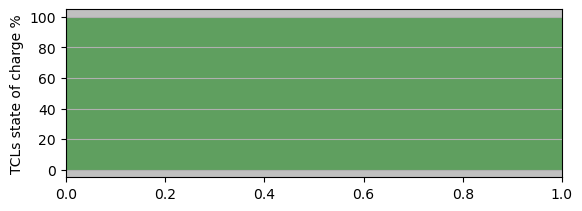

In [11]:
from tcl_env_dqn_1 import MicroGridEnv
env = MicroGridEnv()
agent = SAC(state_size=env.observation_space.shape[0],
                         action_size=env.action_space.n,
                         device='cpu')
        
agent.actor_local.load_state_dict(torch.load("SACSAC_discrete0(2).pth"))
for i in range(2):
            state = env.reset(day=i)
            while True:
                action = agent.get_action(state)
                next_state, reward, done, _ = env.step(action)
                state = next_state
                if done:
                    env.render()
                    break